# Introduction to VoxelMorph
[Adrian Dalca](http://adalca.mit.edu) and Andrew Hoopes    
Introductory slides for this tutorial are [here](https://github.com/learn2reg/tutorials2019/blob/master/slides/Learn2reg_tutorial_unsupervided_AdrianDalca.pdf). 

This is a short tutorial to get you started with [VoxelMorph](https://github.com/voxelmorph/voxelmorph): deep-learning based registration.

### Outline
- **Core concepts with MNIST**   
We will first learn to deal with data, building a model, training, registration and generalization
- **More realistic complexity: Brain MRI (2D slices)**  
We will then show how these models work for 2d slices of brain scans, presenting a more complex scenario    
- **Realistic 3D Brain MRI**  
We will illustrate full 3D registration
- **Advances topics**  
Finally, we close with more advanced topics, including diffeomorphisms and fine-tuning deformations

---

We'll start with some common imports  

In [1]:
# imports
import os, sys

# voxel morph imports
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

#semi-supervised learning
from numpy import savez_compressed

# dataset import
import h5py

# image manipulation
import numpy as np
import scipy.ndimage as ndi
import cv2

#custom functions
import utilitary as util

#plotting
import matplotlib.pyplot as plt

#fix seed to avoid training and testing sets mixing
np.random.seed(336699)

# Registration of Brain MRI

In [2]:
# import dataset with images stored in "frame"
#for some frames, a label mask is available under "mask"
hf = h5py.File("epfl3.h5", "r")

In [3]:
#create training/testing sets
nb_entries = len(hf.keys())
list_keys = list(hf.keys())
keys_random = np.random.permutation(list_keys)

keys_train = keys_random[:int(nb_entries*0.8)]
keys_test  = keys_random[int(nb_entries*0.8):]

In [4]:
#load the training set + normalization
slices_train = np.zeros((len(keys_train),112,112,32))
for i, key in enumerate(keys_train):
    slices_train[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

In [5]:
#load the training set + normalization
slices_test = np.zeros((len(keys_test),112,112,32))
for i, key in enumerate(keys_test):
    slices_test[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

In [6]:
# extract some brains
idx = np.random.randint(0, len(slices_train), 4)
example_digits = [f for f in slices_train[idx, ...]]

#2D-rization with maximal intensity projection
MIP_example = util.np_MIP(slices_train, idx, 2)
plots = [MIP_example[i] for i in range (len(MIP_example))]

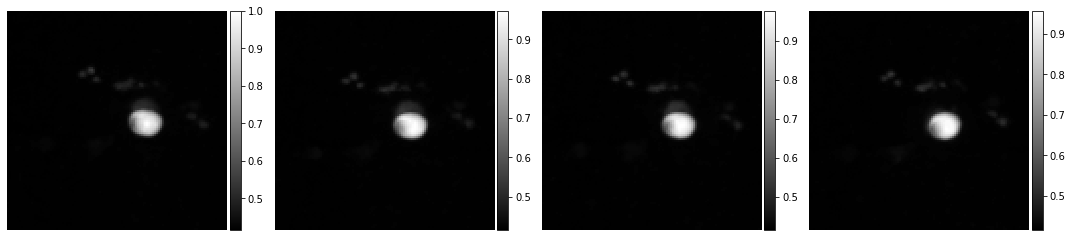

In [7]:
# visualize
ne.plot.slices(plots, cmaps=['gray'], do_colorbars=True, grid=[1,4]);

### 2D MODEL

In [7]:
# configure unet input shape (concatenation of moving and fixed images)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model using VxmDense
inshape = slices_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

In [8]:
# let's test it
train_generator = util.vxm_data_generator(slices_train[30:],
                                          idx_fixed=12,
                                          batch_size=2)
val = util.create_xy(slices_train[:30], 3)

Looks good, time to **train the model**

In [9]:
hist = vxm_model.fit(train_generator,
                     validation_data=val,
                     validation_batch_size = 2,
                     epochs=3, steps_per_epoch=1, verbose=1);

Epoch 1/3
1/1 [==============================] - 32s 32s/step - loss: 4.5841e-04 - vxm_dense_transformer_loss: 4.5841e-04 - vxm_dense_flow_loss: 7.3478e-10 - val_loss: 2.7113e-04 - val_vxm_dense_transformer_loss: 2.7092e-04 - val_vxm_dense_flow_loss: 4.2950e-06
Epoch 2/3
1/1 [==============================] - 31s 31s/step - loss: 4.0527e-04 - vxm_dense_transformer_loss: 4.0505e-04 - vxm_dense_flow_loss: 4.2892e-06 - val_loss: 2.6929e-04 - val_vxm_dense_transformer_loss: 2.6863e-04 - val_vxm_dense_flow_loss: 1.3266e-05
Epoch 3/3
1/1 [==============================] - 30s 30s/step - loss: 2.7756e-04 - vxm_dense_transformer_loss: 2.7690e-04 - vxm_dense_flow_loss: 1.3260e-05 - val_loss: 2.6809e-04 - val_vxm_dense_transformer_loss: 2.6698e-04 - val_vxm_dense_flow_loss: 2.2220e-05


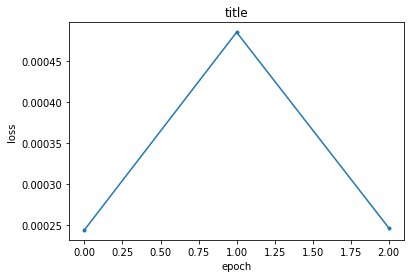

In [26]:
# as before, let's visualize what happened
util.plot_history(hist)

In [27]:
val_input, _ = next(train_generator)

In [28]:
# prediction
val_pred = vxm_model.predict(val_input)

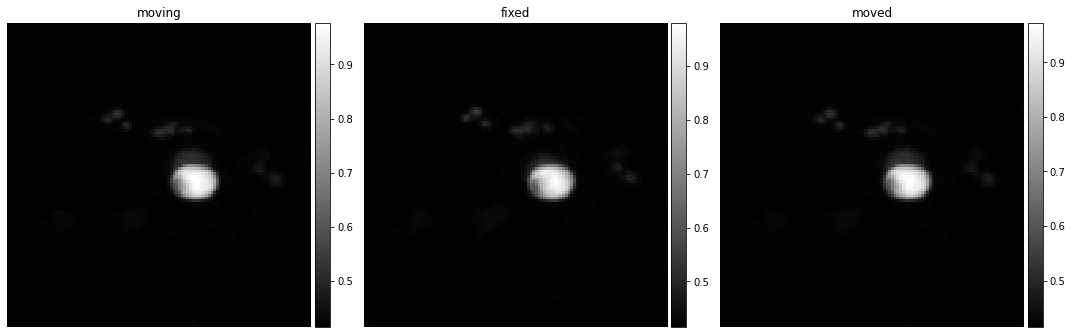

In [29]:
# visualize registration
images = [np.squeeze(util.np_MIP(np.squeeze(img),[0],2)) for img in val_input+[val_pred[0]]] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles[:-1], cmaps=['gray'], do_colorbars=True);

# Evaluation

Evaluating registration results is tricky. The first tendancy is to look at the images (as above), and conclude that if they match, The registration has succeeded.

However, this can be achieved by an optimization that only penalizes the image matching term. For example, next we compare our model with one that was trained on maximizing MSE only (without smoothness loss).

In [94]:
# prediction from model with MSE + smoothness loss
vxm_model.load_weights('weights.keras')
our_val_pred = vxm_model.predict(val_input)

# prediction from model with just MSE loss
vxm_model.load_weights('weights.keras')
mse_val_pred = vxm_model.predict(val_input)

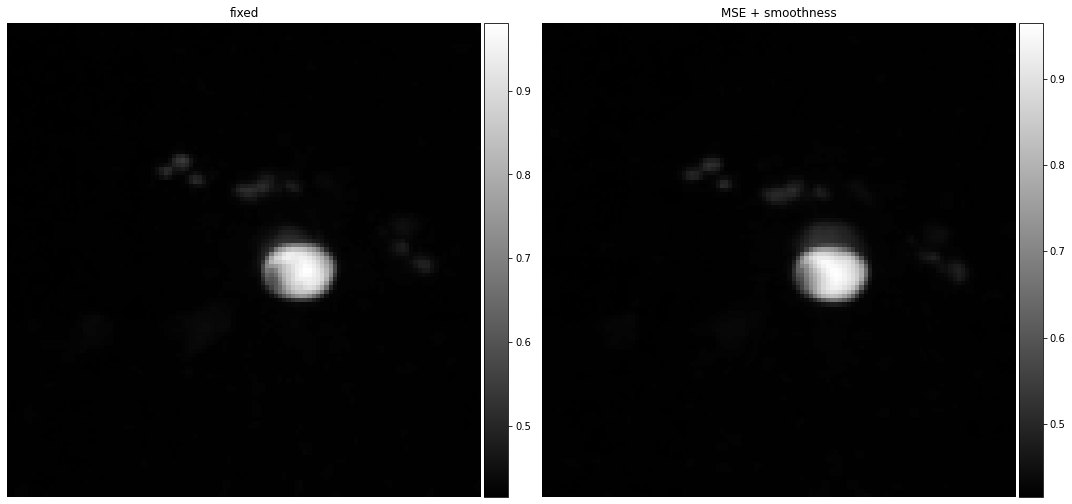

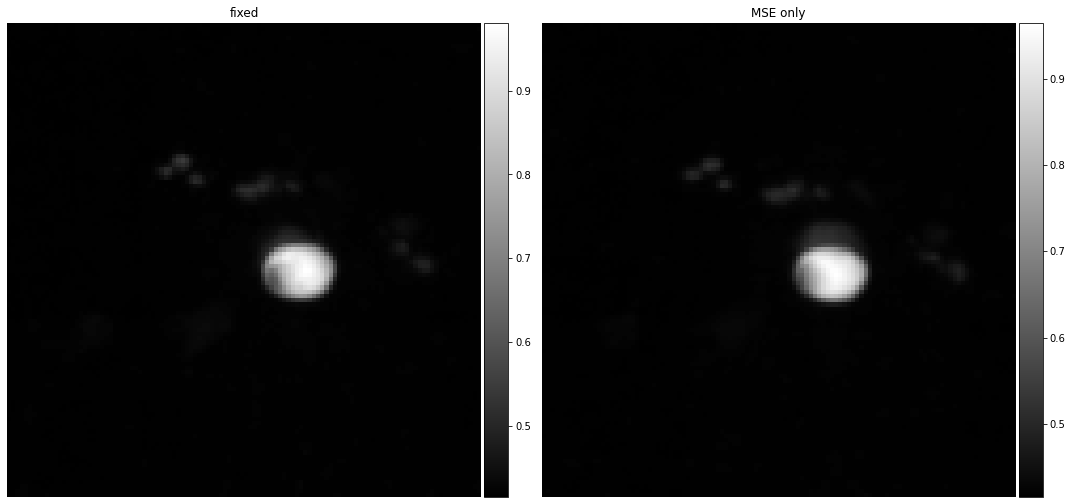

In [95]:
# visualize MSE + smoothness model output
images = [np.squeeze(util.np_MIP(np.squeeze(img),[0],2)) for img in [val_input[1], our_val_pred[0]]]
titles = ['fixed', 'MSE + smoothness', 'flow']
ne.plot.slices(images, titles=titles[:-1], cmaps=['gray'], do_colorbars=True);

# visualize MSE model output
images = [np.squeeze(util.np_MIP(np.squeeze(img),[0],2)) for img in [val_input[1], mse_val_pred[0]]]
titles = ['fixed', 'MSE only', 'flow']
ne.plot.slices(images, titles=titles[:-1], cmaps=['gray'], do_colorbars=True);

# 3D SAHAND DATASET

### Model

In [6]:
# our data will be of shape 112 x 112 x 32
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

# build model using VxmDense
inshape = slices_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

Instructions for updating:
Use fn_output_signature instead


## Load pre-trained model

In [7]:
#load weight obtained on December the 11th
vxm_model.load_weights('wght_3d_0.0005.keras')

## OR declare a new model

In [11]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

### Validation data

In [8]:
#load the training set + normalization
slices_train_3d = np.zeros((len(keys_train),112,112,32))
for i, key in enumerate(keys_train):
    slices_train_3d[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

In [10]:
#load the training set + normalization
slices_test_3d = np.zeros((len(keys_test),112,112,32))
for i, key in enumerate(keys_test):
    slices_test_3d[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

In [ ]:
# create a generator with a constant fixed volume (keys='853')
#chose this one because middle of the movie and provided with a label mask
train_generator = util.vxm_data_generator(slices_train_3d[31:],
                                          vol_fixed=np.array(hf.get('853')["frame"][0][:,:,:])/255,
                                          batch_size=2)

xy_val = util.create_xy_3d(slices_train_3d[:31], np.array(hf.get('853')["frame"][0][:,:,:])/255)

hist = vxm_model.fit(train_generator,
                     validation_data=xy_val,
                     epochs=3, 
                     steps_per_epoch=1, verbose=1)

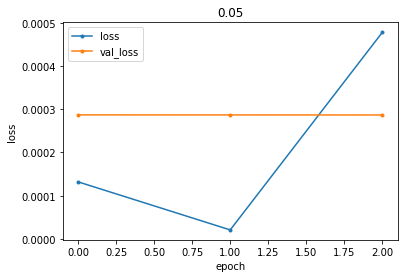

In [17]:
util.plot_history(hist, 0.05, loss_name=['loss','val_loss'], save_name = 'title')

Now let's register.

In [218]:
# print keys in test with labels mask
for i in keys_test[300:]:
    if len(hf.get(i)) > 1:
        print(i)

1138
415
511
1649
904


In [36]:
# simple input, to show warping on the labels mask
val_input = [
             (np.array(hf.get('1649')["frame"][0][:,:,:])/255)[np.newaxis, ..., np.newaxis],
             (np.array(hf.get('853')["frame"][0][:,:,:])/255)[np.newaxis, ..., np.newaxis]
            ]

val_input[1].shape

In [37]:
# predict the transformation
val_pred = vxm_model.predict(val_input);

In [38]:
val_pred[1][0].shape

(112, 112, 32, 3)

In [39]:
# extract the result
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

In [40]:
# display the moving, fixed and moved-prediction
mid_slices_moving = [np.take(val_input[0].squeeze(), vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_fixed = [np.take(val_input[1].squeeze(), vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_moving + mid_slices_fixed + mid_slices_pred,
               cmaps=['gray'],
               do_colorbars=True,
               grid=[3,3]);

NameError: name 'vol_shape' is not defined

## Label warping

In [162]:
# declare a model of the labels warping
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

In [164]:
# labels corresponding to the frame declared above
labels = [
             (np.array(hf.get('1649')["mask"])/255),
             (np.array(hf.get('853')["mask"])/255)
            ]

In [165]:
# predict the labels transformation
warped_seg = warp_model.predict([labels[0][np.newaxis, ..., np.newaxis], pred_warp])

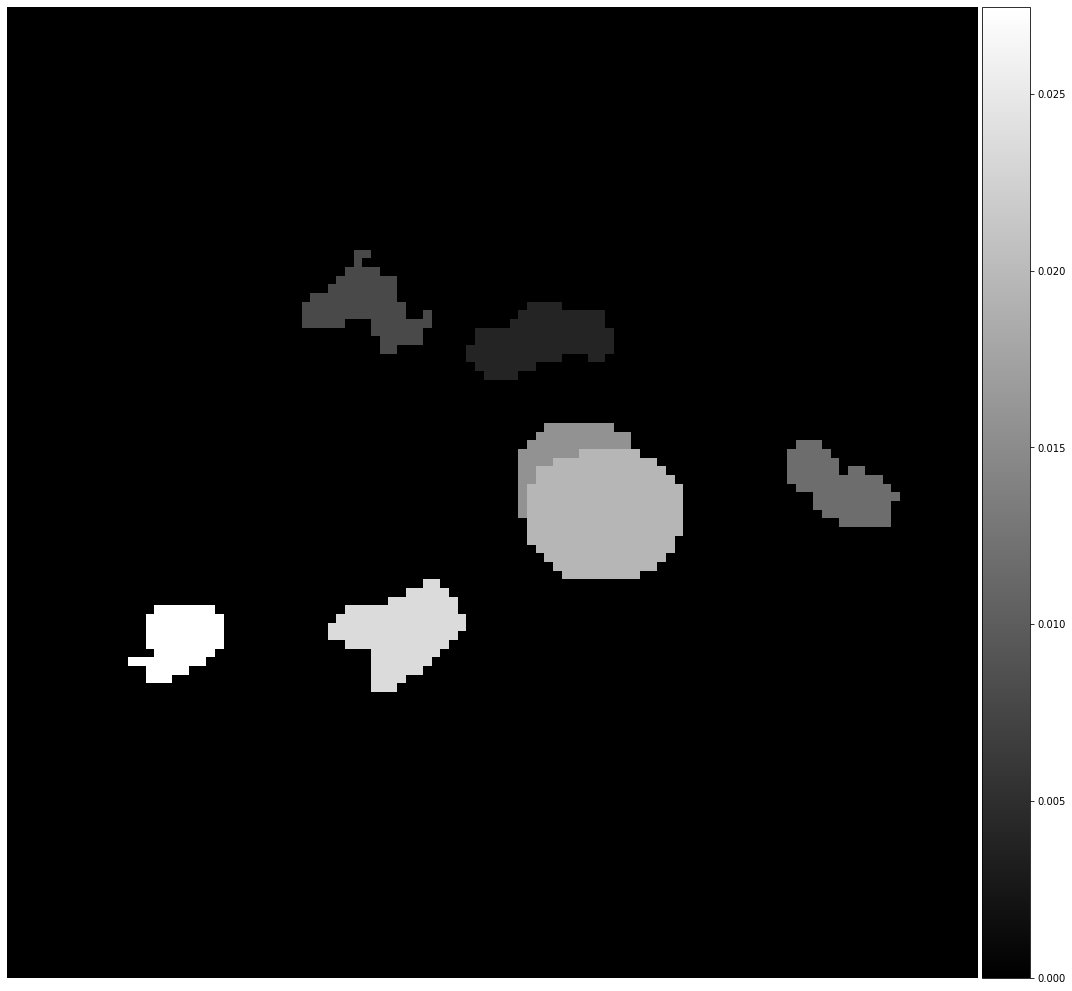

In [166]:
# plot the fixed image label mask (MIP)
ne.plot.slices(np.max(labels[1].squeeze(), axis=2), cmaps=['gray'], do_colorbars=True);

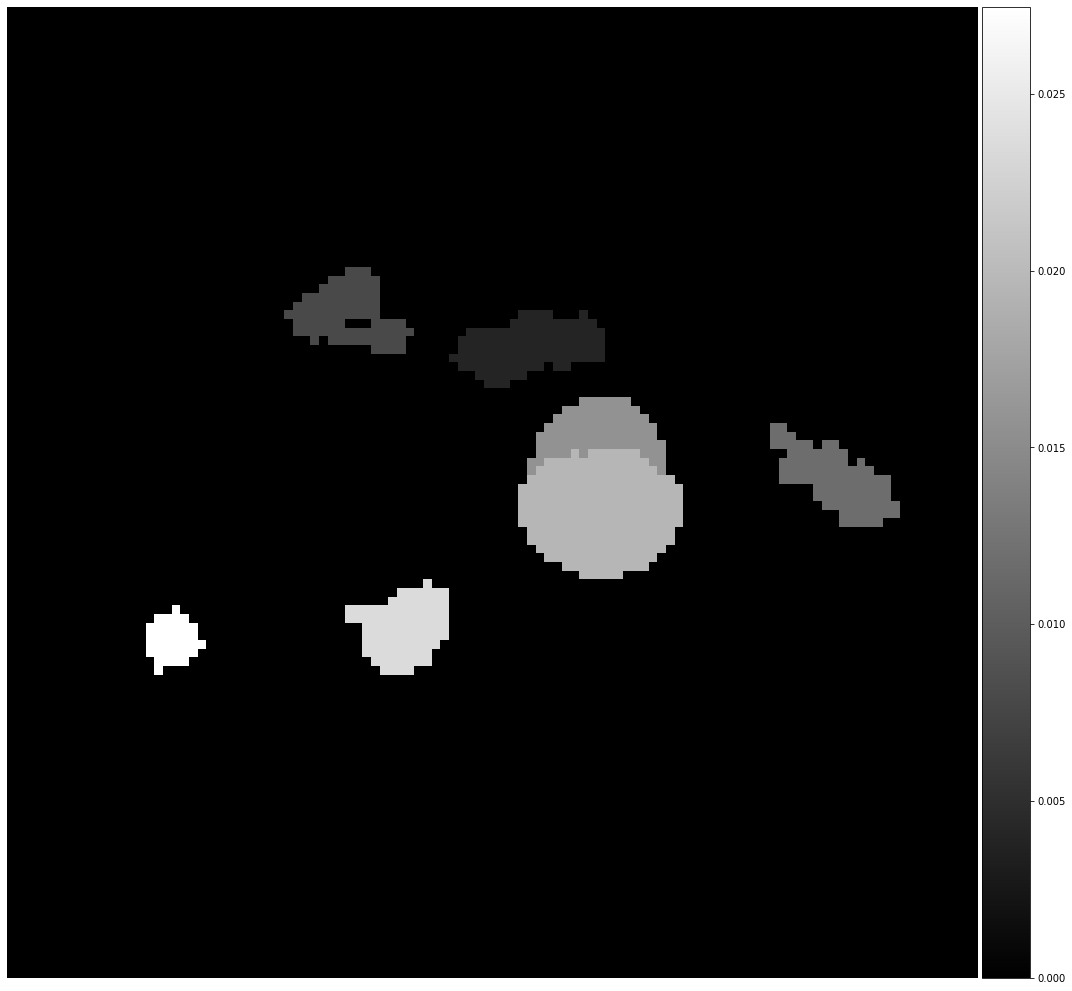

In [167]:
# plot the prediction label mask (MIP)
ne.plot.slices(np.max(warped_seg.squeeze(), axis=2), cmaps=['gray'], do_colorbars=True);

In [170]:
# add color to the plot
from pystrum.pytools.plot import jitter
import matplotlib

[ccmap, scrambled_cmap] = jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

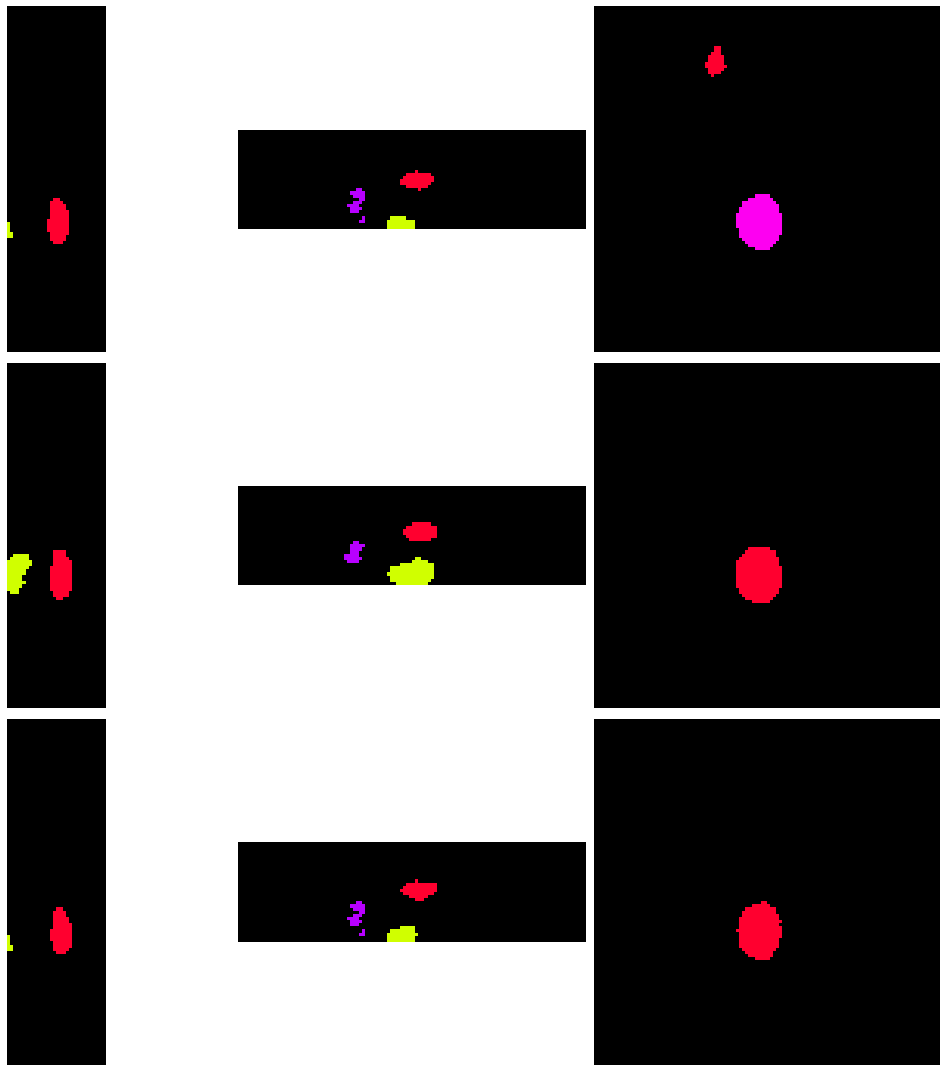

In [212]:
# plot the labels moving, fixed and prediction
mid_slices_moving = [np.take(labels[0].squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_moving[1] = np.rot90(mid_slices_moving[1], 1)
mid_slices_moving[2] = np.rot90(mid_slices_moving[2], -1)

mid_slices_fixed = [np.take(labels[1].squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

slices = mid_slices_moving + mid_slices_fixed + mid_slices_pred

ne.plot.slices(slices, cmaps = [ccmap], grid=[3,3]);

## Semi Supervised

In [4]:
# keys with labels mask
masked_train = [i for i in keys_train if (len(hf.get(i)) > 1)]
masked_test = [i for i in keys_test if (len(hf.get(i)) > 1)]

labels_train_3d_semisup = np.zeros((len(masked_train),112,112,32))
slices_train_3d_semisup = np.zeros((len(masked_train),112,112,32))

labels_test_3d_semisup = np.zeros((len(masked_test),112,112,32))
slices_test_3d_semisup = np.zeros((len(masked_test),112,112,32))

#load the training set + normalization
for i, key in enumerate(masked_train):
    labels_train_3d_semisup[i] = np.array(hf.get(key)["mask"][0])
    slices_train_3d_semisup[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

    #load the test set + normalization
for i, key in enumerate(masked_test):
    labels_test_3d_semisup[i] = np.array(hf.get(key)["mask"][0])
    slices_test_3d_semisup[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255

## create a true semi-supervised training set

In [ ]:
#get the index of keys with frame + labels
masked_train = [i for i in keys_train if (len(hf.get(i)) > 1)]

#preallocation
labels_train_3d_semisup = np.zeros((len(keys_train),112,112,32))
slices_train_3d_semisup = np.zeros((len(keys_train),112,112,32))

#load the training set + normalization
for i, key in enumerate(keys_train):
    if i in masked_train:
        labels_train_3d_semisup[i] = np.array(hf.get(key)["mask"])
        slices_train_3d_semisup[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
    else:
        labels_train_3d_semisup[i] = np.zeros((112, 112,  32))
        slices_train_3d_semisup[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
        
# generate a file for each semi-supervised training entry
for i in range(len(slices_train_3d_semisup)):
    savez_compressed('vol'+str(i)+'.npz',
                     vol=slices_train_3d_semisup[i],
                     seg=labels_train_3d_semisup[i])

In [4]:
#get the index of keys with frame + labels
masked_test = [i for i in keys_test if (len(hf.get(i)) > 1)]

#preallocation
labels_test_3d_semisup = np.zeros((len(keys_test),112,112,32))
slices_test_3d_semisup = np.zeros((len(keys_test),112,112,32))

#load the test set + normalization
for i, key in enumerate(keys_test[:51]):
    if i in masked_test:
        labels_test_3d_semisup[i] = np.array(hf.get(key)["mask"])
        slices_test_3d_semisup[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
    else:
        labels_test_3d_semisup[i] = np.zeros((112, 112,  32))
        slices_test_3d_semisup[i] = np.array(hf.get(key)["frame"][0][:,:,:])/255
        
# generate a file for each semi-supervised training entry
for i in range(len(slices_test_3d_semisup)):
    savez_compressed('val'+str(i)+'.npz',
                     vol=slices_test_3d_semisup[i],
                     seg=labels_test_3d_semisup[i])

In [5]:
# our data will be of shape 112 x 112 x 32
vol_shape = (112, 112, 32)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

lambda_param = 0.05
loss_weights = [1, lambda_param]

# declare the model, using all 7 labels values
vxm_model_semisup = vxm.networks.VxmDenseSemiSupervisedSeg(inshape=vol_shape,
                                                           nb_labels=7,
                                                           nb_unet_features=nb_features,
                                                           int_steps=0);

vxm_model_semisup.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                          loss=losses,
                          loss_weights=loss_weights)

Instructions for updating:
Use fn_output_signature instead


In [6]:
#nb_entries
l_train = len(keys_train)
vols_names = ['vol'+str(i)+'.npz' for i in range(l_train)]

l_test = len(keys_test)
vals_names = ['val'+str(i)+'.npz' for i in range(l_test)]

In [138]:
# create the generator
label_vals = np.array([1,2,3,4,5,6,7])
train_generator = vxm.generators.semisupervised(vol_names=vols_names,
                                                labels=label_vals
                                               )

val_generator = vxm.generators.semisupervised(vol_names=vals_names,
                                                labels=label_vals
                                               )

vali = [next(val_generator) for i in range(3)]

In [140]:
# train the model
hist = vxm_model_semisup.fit(train_generator,
                             validation_data=vali,
                             validation_batch_size=1,
                             epochs=10,
                             steps_per_epoch=2,
                             verbose=1);

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 2.3603e-04 - vxm_dense_transformer_loss: 2.3531e-04 - vxm_dense_flow_loss: 1.4305e-05

KeyboardInterrupt: 

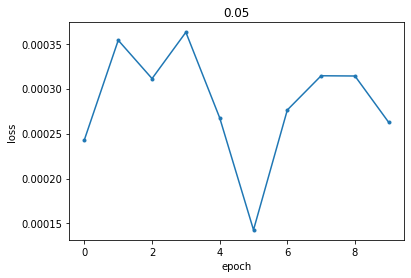

In [13]:
util.plot_history(hist, 0.05, loss_name=['loss'], save_name = 'title')

In [29]:
vxm_model_semisup.fit?